
--- Run 000 of 001 ---
Running: Activation=XSINELU at 2025-07-15 17:11:50
Epoch 1/501
782/782 ━━━━━━━━━━━━━━━━━━━━ 104s 124ms/step - accuracy: 0.4205 - loss: 1.5971 - val_accuracy: 0.5268 - val_loss: 1.2838
Epoch 2/501
782/782 ━━━━━━━━━━━━━━━━━━━━ 96s 123ms/step - accuracy: 0.6105 - loss: 1.0941 - val_accuracy: 0.5553 - val_loss: 1.3167
Epoch 3/501
782/782 ━━━━━━━━━━━━━━━━━━━━ 95s 122ms/step - accuracy: 0.6633 - loss: 0.9469 - val_accuracy: 0.6492 - val_loss: 0.9843
Epoch 4/501
782/782 ━━━━━━━━━━━━━━━━━━━━ 97s 124ms/step - accuracy: 0.7036 - loss: 0.8439 - val_accuracy: 0.6594 - val_loss: 0.9638
Epoch 5/501
782/782 ━━━━━━━━━━━━━━━━━━━━ 99s 127ms/step - accuracy: 0.7293 - loss: 0.7777 - val_accuracy: 0.6471 - val_loss: 1.0324
Epoch 6/501
782/782 ━━━━━━━━━━━━━━━━━━━━ 93s 119ms/step - accuracy: 0.7455 - loss: 0.7215 - val_accuracy: 0.6715 - val_loss: 0.9508
Epoch 7/501
782/782 ━━━━━━━━━━━━━━━━━━━━ 92s 117ms/step - accuracy: 0.7658 - loss: 0.6795 - val_accuracy: 0.7043 - val_loss: 0.8642


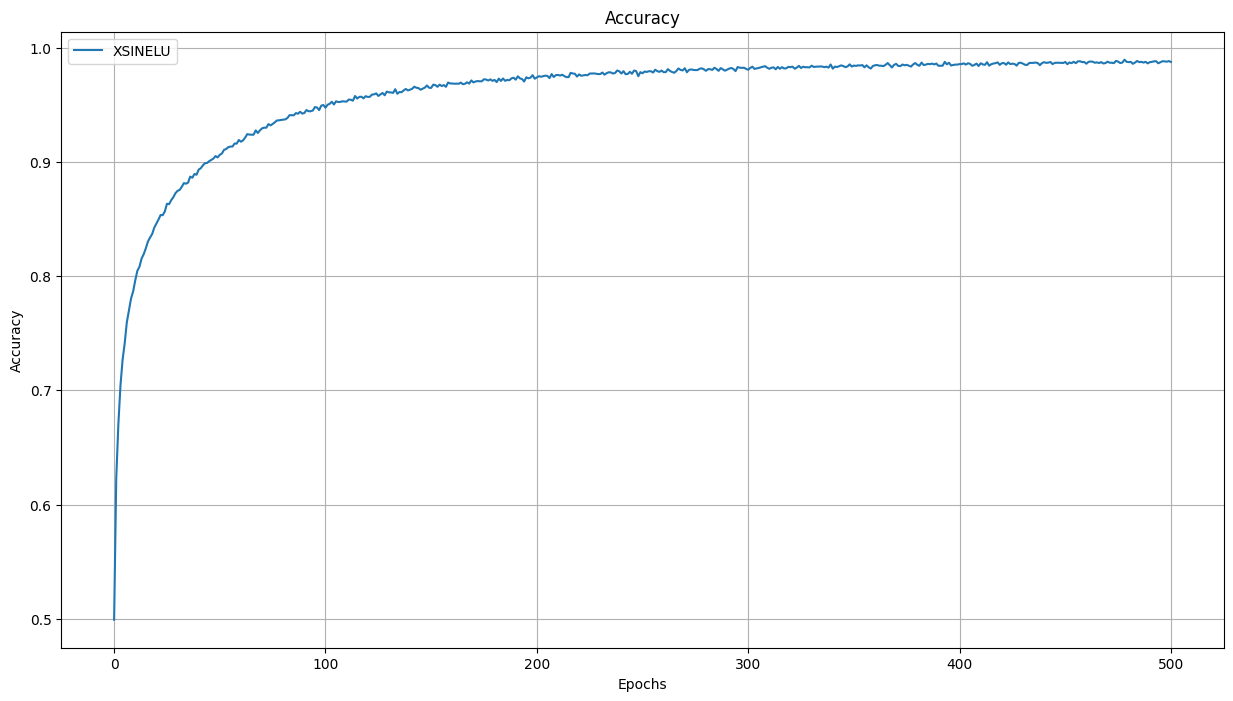

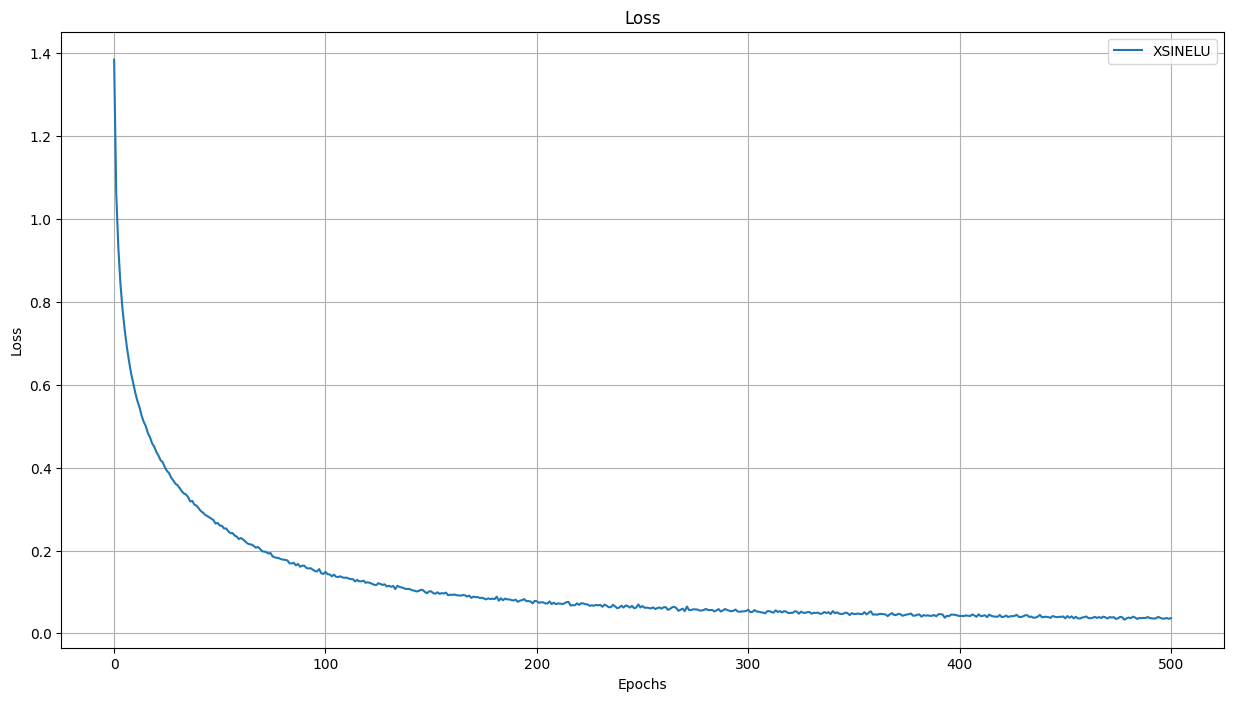

 ----- Data -------- 
Details in results for round 000:

Activation: XSINELU
  accuracy: [0.49932    0.62283999 0.67004001 0.70422    0.72667998 0.74107999
 0.75941998 0.77002001 0.78030002 0.78659999 0.79629999 0.80466002
 0.80822003 0.8154     0.81922001 0.82432002 0.83028001 0.83374
 0.83686    0.84240001 0.84587997 0.84952003 0.85347998 0.85329998
 0.85667998 0.86328    0.86298001 0.8664     0.86900002 0.87247998
 0.87462002 0.87537998 0.87805998 0.88138002 0.88084    0.88182002
 0.88705999 0.88608003 0.88936001 0.88867998 0.89315999 0.8944
 0.89686    0.89877999 0.89899999 0.90060002 0.90167999 0.90288001
 0.90508002 0.90384001 0.90616    0.90726    0.91049999 0.91118002
 0.91281998 0.91333997 0.91338003 0.91601998 0.91593999 0.91908002
 0.91759998 0.91876    0.92118001 0.92423999 0.92383999 0.92372
 0.92378002 0.92750001 0.92523998 0.92754    0.92931998 0.92989999
 0.92982    0.93300003 0.93190002 0.93309999 0.93453997 0.93618
 0.93632001 0.93664002 0.93686002 0.93713999 0.938359

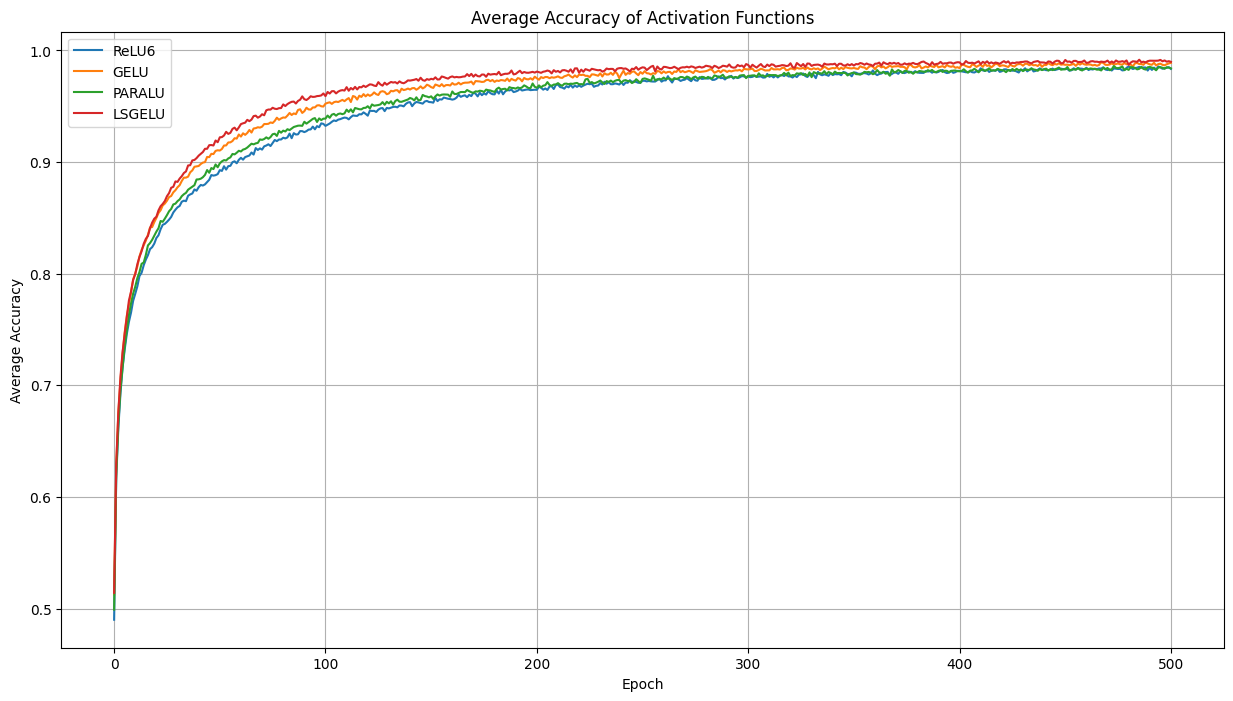

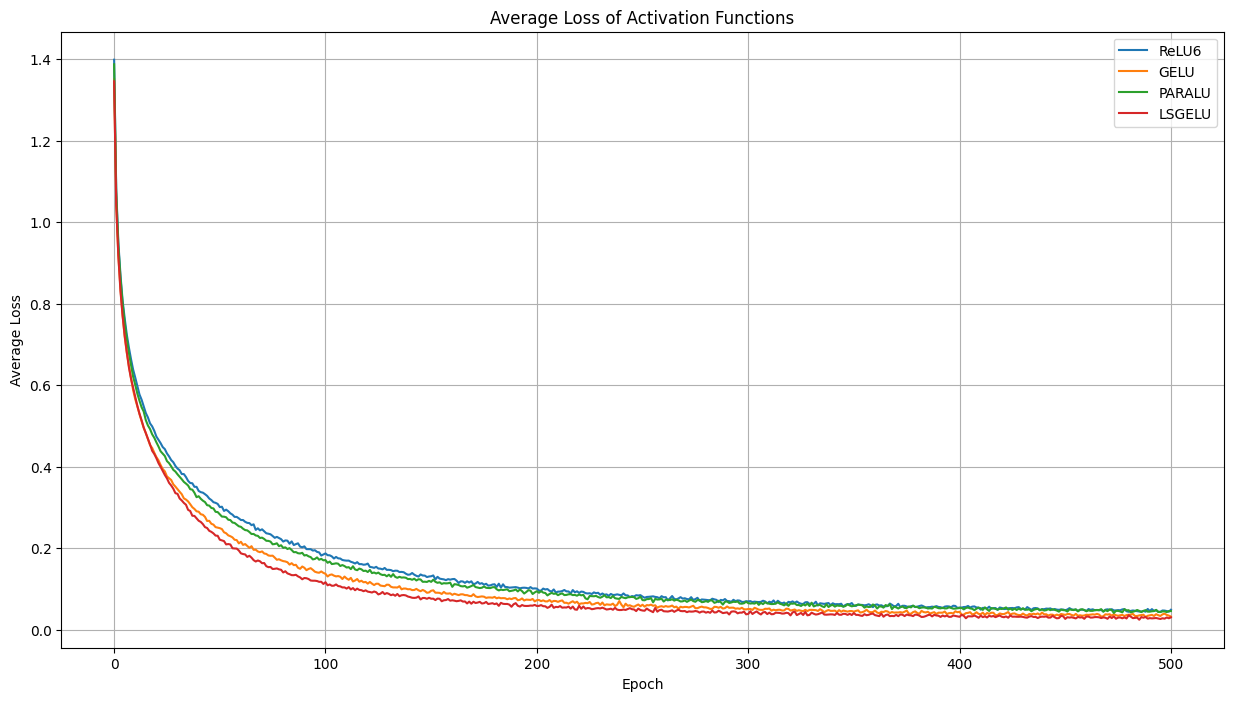


--- Loading accuracy_000.npz and loss_000.npz ---
Keys accuracy: ['ReLU6', 'GELU', 'PARALU', 'LSGELU']
Keys loss: ['ReLU6', 'GELU', 'PARALU', 'LSGELU']


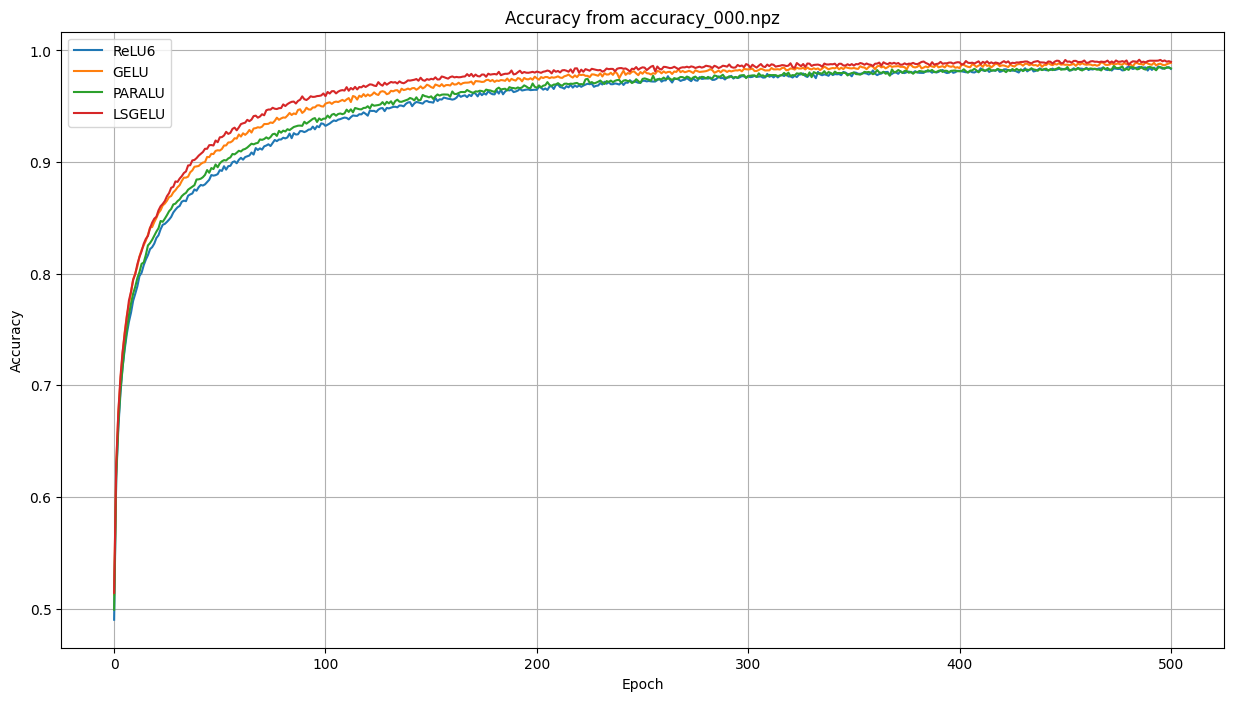

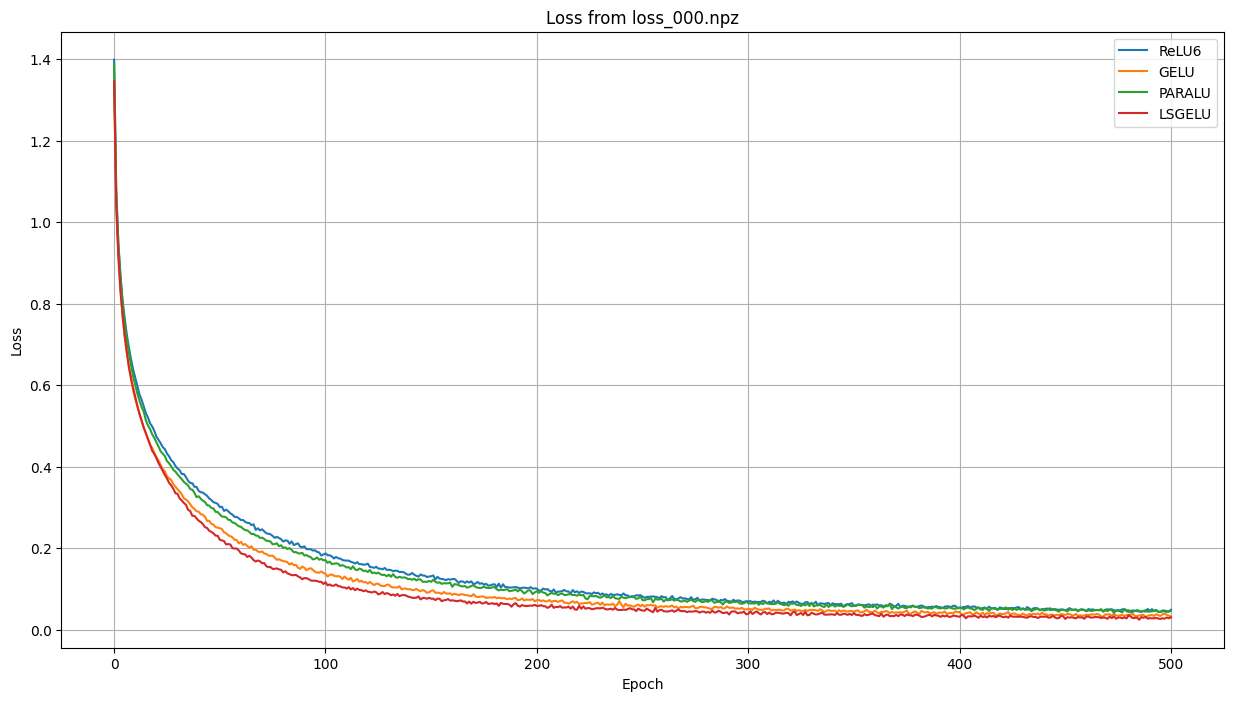


END at 2025-07-16 08:03:02


In [2]:
#--- 2025-07-15 17-09 – by Dr. Thawatchai Chomsiri  
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation
from tensorflow.keras.models import Model
import datetime

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Flatten, Dense
import matplotlib.pyplot as plt
import datetime
import numpy as np
import os
import re
import math
import pickle


# Define relu6
def relu6(x):
    return tf.keras.activations.relu(x, max_value=6)

# Define paralu
def paralu(x):
    cube_root_of_three = 3 ** (1/3)
    return tf.where(
        x >= 0,
        x,
        tf.where(
            x >= -cube_root_of_three,
            x * (1/3) * tf.pow(x + cube_root_of_three, 3),
            tf.zeros_like(x)
        )
    )

def lsgelu(x):    # Left-Shifted GELU with 1 range
    return x * 0.5 * (1 + tf.math.erf((x + 1.5) / tf.sqrt(2.0)))

def xsinelu(x):
    Pi = math.pi
    return tf.where(
        x >= Pi,
        x,
        tf.where(
            x >= -1 * Pi,
            (1/2) * (( ((x * tf.sin(x)) + (x * x) ) / Pi ) + x),
            tf.zeros_like(x)
        )
    )  
 

# Function สำหรับสร้างโมเดล
def build_model(activation_fn):
    inputs = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), strides=2, padding='same', activation=None)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation_fn)(x)

    def bottleneck_block(x, filters):
        dw = DepthwiseConv2D((3, 3), padding='same')(x)
        dw = BatchNormalization()(dw)
        dw = Activation(activation_fn)(dw)

        pw = Conv2D(filters, (1, 1), padding='same')(dw)
        pw = BatchNormalization()(pw)
        pw = Activation(activation_fn)(pw)
        return pw

    x = bottleneck_block(x, 64)
    x = bottleneck_block(x, 64)
    x = MaxPooling2D((2, 2))(x)
    x = bottleneck_block(x, 128)
    x = bottleneck_block(x, 128)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

activations_list = {
    #'LSGELU': lsgelu,
    #'GELU': tf.nn.gelu,
    #'PARALU': paralu,
    #'ReLU6': 'relu6',
    'XSINELU': xsinelu,
    
}

epochs = 501  ################
num_runs = 1 ###############
batch_size = 64 ###############
results = {
    'activation': [],
    'accuracy_per_epoch': []
}
accuracy_summary = {}

for run_idx in range(num_runs):
    print(f"\n--- Run {run_idx:03d} of {num_runs:03d} ---")
    results = {}
    accuracy_results = {}
    loss_results = {}
    
    for act_name, act_fn in activations_list.items():
        print(f"Running: Activation={act_name} at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

        # เทรน
        model = build_model(act_fn)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

        history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), batch_size=batch_size)
        
        print(f"Running: Activation={act_name} at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")   
        results[act_name] = {key: np.array(val) for key, val in history.history.items()}
        print(f"Details in results for round {run_idx:03d}:")
        for act_name, metrics_dict in results.items():
            print(f"\nActivation: {act_name}")
            for metric_name, metric_values in metrics_dict.items():
                print(f"  {metric_name}: {metric_values}")

        # Plot Accuracy
        plt.figure(figsize=(15,8))
        for key, hist_vals in results.items():
            plt.plot(hist_vals['accuracy'], label=key)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy')
        plt.legend()
        plt.grid()
        plt.show()
        # Plot Loss
        plt.figure(figsize=(15,8))
        for key, hist_vals in results.items():
            plt.plot(hist_vals['loss'], label=key)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()
        plt.grid()
        plt.show()

        np.savez(f"accuracy_{run_idx:03d}_{act_name}.npz", accuracy=np.array(history.history['accuracy']))
        np.savez(f"loss_{run_idx:03d}_{act_name}.npz", loss=np.array(history.history['loss']))
        
        accuracy_results[act_name] = np.array(history.history['accuracy'])
        loss_results[act_name] = np.array(history.history['loss'])

    print(f" ----- Data -------- ")
    results[act_name] = {key: np.array(val) for key, val in history.history.items()}
    print(f"Details in results for round {run_idx:03d}:")
    for act_name, metrics_dict in results.items():
        print(f"\nActivation: {act_name}")
        for metric_name, metric_values in metrics_dict.items():
            print(f"  {metric_name}: {metric_values}")

    print(f" ------------------- ")
    ###np.savez(f"accuracy_{run_idx:03d}.npz", **accuracy_results)
    ###np.savez(f"loss_{run_idx:03d}.npz", **loss_results)

folder_path = '.'
accuracy_files = sorted([f for f in os.listdir(folder_path) if re.match(r'accuracy_\d+\.npz', f)])
loss_files = sorted([f for f in os.listdir(folder_path) if re.match(r'loss_\d+\.npz', f)])

accuracy_collections = {}
for fname in accuracy_files:
    acc_data = np.load(os.path.join(folder_path, fname), allow_pickle=True)
    for key in acc_data.files:
        if key not in accuracy_collections:
            accuracy_collections[key] = []
        accuracy_collections[key].append(acc_data[key])

accuracy_avg = {}
for act_name, vals in accuracy_collections.items():
    stacked = np.vstack(vals)
    accuracy_avg[act_name] = np.mean(stacked, axis=0)

loss_collections = {}
for fname in loss_files:
    los_data = np.load(os.path.join(folder_path, fname), allow_pickle=True)
    for key in los_data.files:
        if key not in loss_collections:
            loss_collections[key] = []
        loss_collections[key].append(los_data[key])

loss_avg = {}
for act_name, vals in loss_collections.items():
    stacked = np.vstack(vals)
    loss_avg[act_name] = np.mean(stacked, axis=0)

plt.figure(figsize=(15,8))
for i, act_name in enumerate(accuracy_avg):
    plt.plot(accuracy_avg[act_name], label=act_name)
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy of Activation Functions')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15,8))
for i, act_name in enumerate(loss_avg):
    plt.plot(loss_avg[act_name], label=act_name)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Loss of Activation Functions')
plt.legend()
plt.grid()
plt.show()

for i in range(len(accuracy_files)):
    fname_acc = accuracy_files[i]
    fname_loss = loss_files[i]
    print(f"\n--- Loading {fname_acc} and {fname_loss} ---")
    acc_data = np.load(os.path.join(folder_path, fname_acc), allow_pickle=True)
    loss_data = np.load(os.path.join(folder_path, fname_loss), allow_pickle=True)

    print("Keys accuracy:", list(acc_data.keys()))
    print("Keys loss:", list(loss_data.keys()))

    activation_names = list(acc_data.files)

    # Plot Accuracy
    plt.figure(figsize=(15,8))
    for name in activation_names:
        plt.plot(acc_data[name], label=name)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy from {fname_acc}')
    plt.legend()
    plt.grid()
    plt.show()
    # Plot Loss
    plt.figure(figsize=(15,8))
    for name in activation_names:
        plt.plot(loss_data[name], label=name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss from {fname_loss}')
    plt.legend()
    plt.grid()
    plt.show()
   
print(f"\nEND at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
